## Portfolio Part 3

Student Name: *Umut Demirhan* 

Student ID: *46739106*

In this Portfolio task you will continue working with the movielens data collected by the GroupLens Research Project at the University of Minnesota. The columns in the dataset are a little bit different from the ones provided in the previous Portfolio tasks, where the 'rating' column is replaced by the 'feedback' column. There are two values regarding the 'feedback' with 1 indicating the user likes the corresponding movie; otherwise 0. 

The header of the csv file is shown below. 

| userId | age | gender | occupation| movieId | feedback | genre | timestamp |
    | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | 
    
#### Description of Fields

* __userId__ - the user's id
* __age__ - the user's age
* __gender__ - the user's gender
* __occupation__ - the user's occupation
* __movieId__ - the movie's id
* __feedback__ - the user's feedback towards the movie (1 means 'like'; 0 means 'dislike')
* __genre__ - the genre of the movie
* __timestamp__ - the timestamp indicating when the user rated the movie

Note that, a same user (i.e., a same userId) corresponds to a same age/gender/occupation; a same movie (i.e., a same movieId) corresponds to a same genre; a same user (i.e., a same userId) may like multiple movies and a same movie (i.e., a same movieId) may be preferred by multiple users.


Your high level goal in this notebook is to try to build and evaluate predictive models for feedback from available features - predict the value of the __feedback__ field in the data from some of the other fields. Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.

Note: you are not being evaluated on the ___accuracy___ of the model but on the ___process___ that you use to generate it. Please use a ___simple Logistic Regression model___ and ___one of the more advanced methods___ covered in recent weeks. Accordingly, discuss the performance of the simple and advanced methods.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('files/movielens_data_feedback.csv')
df.head(10)

,userId,age,gender,occupation,movieId,feedback,genre,timestamp
0,196,49,M,writer,242,0,Comedy,881250949
1,186,39,F,executive,302,0,Crime,891717742
2,22,25,M,writer,377,0,Children,878887116
3,244,28,M,technician,51,0,Romance,880606923
4,166,47,M,educator,346,0,Drama,886397596
5,298,44,M,executive,474,1,War,884182806
6,115,31,M,engineer,265,0,Action,881171488
7,253,26,F,librarian,465,1,Adventure,891628467
8,305,23,M,programmer,451,0,Romance,886324817
9,6,42,M,executive,86,0,Drama,883603013


### Exploration of  the Dataset

In [3]:
# Checking for any null values
df.isnull().sum()

userId        0
age           0
gender        0
occupation    0
movieId       0
feedback      0
genre         0
timestamp     0
dtype: int64

In [4]:
# Revealing information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   userId      100000 non-null  int64 
 1   age         100000 non-null  int64 
 2   gender      100000 non-null  object
 3   occupation  100000 non-null  object
 4   movieId     100000 non-null  int64 
 5   feedback    100000 non-null  int64 
 6   genre       100000 non-null  object
 7   timestamp   100000 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 6.1+ MB


In [5]:
df.shape

(100000, 8)

> We can predict the 'feedback' feature by four other feature; "age", "genre", "gender", "occupation"
To do that, firstly, I will encode categorical features as an integer.

In [6]:
# Convert the related categorical features into numerial values before exploring data set any further
# impoting OrdinalEncoder from sklearn
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder(dtype=int)
df[["genre_code", "gender_code", "occupation_code"]] = ord_enc.fit_transform(df[["genre", "gender", "occupation"]])
df[["genre", "genre_code", "occupation", "occupation_code", "gender", "gender_code"]].head()

,genre,genre_code,occupation,occupation_code,gender,gender_code
0,Comedy,4,writer,20,M,1
1,Crime,5,executive,6,F,0
2,Children,3,writer,20,M,1
3,Romance,13,technician,19,M,1
4,Drama,7,educator,3,M,1


In [7]:
# Creating a new data frame and assigning the target and the features columns to it.
df_pred = df[['feedback','age',"genre_code", "gender_code", "occupation_code"]]
df_pred.describe()

,feedback,age,genre_code,gender_code,occupation_code
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.553750,32.969850,7.466330,0.742600,11.076340
std,0.497105,11.562623,4.891033,0.437204,6.622849
min,0.000000,7.000000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,4.000000,0.000000,4.000000
50%,1.000000,30.000000,7.000000,1.000000,13.000000
75%,1.000000,40.000000,13.000000,1.000000,18.000000
max,1.000000,73.000000,18.000000,1.000000,20.000000


### Remark
As we can conclude from the statistics above,
* There are more users who like the movies than others(dislikers).
* The mean age of users is approximately 33 with the oldest 73 and youngest 7 years old.
* statistics of Genre, gender and occupation mean not much above.


### Visualizations
Let's examine the data with some visualizations

<Figure size 432x432 with 0 Axes>

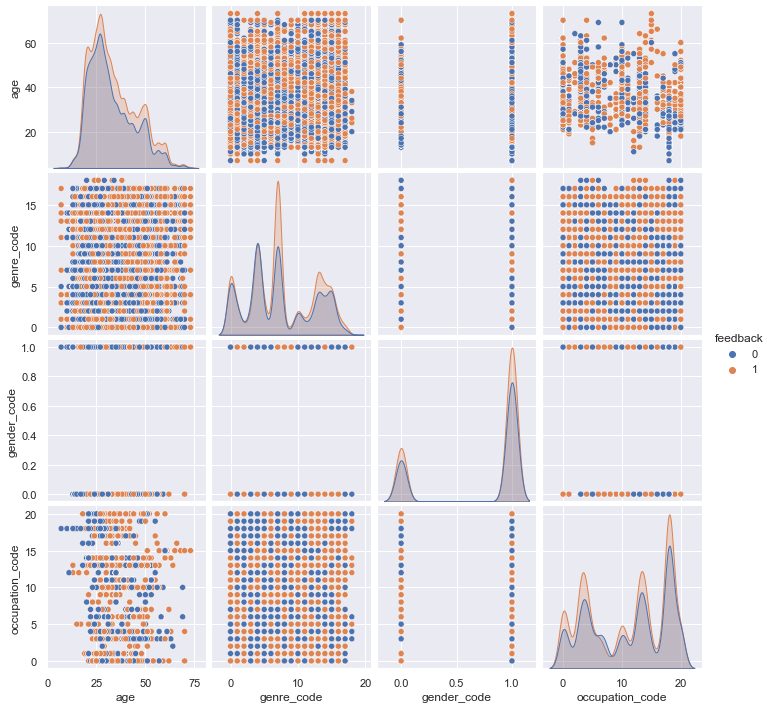

In [8]:
# Have a look at the distributions of feedbacks with the features
sns.set_style('darkgrid')
plt.figure(figsize=(6,6))
sns.pairplot(df_pred, hue= 'feedback')

<AxesSubplot:xlabel='genre_code', ylabel='feedback'>

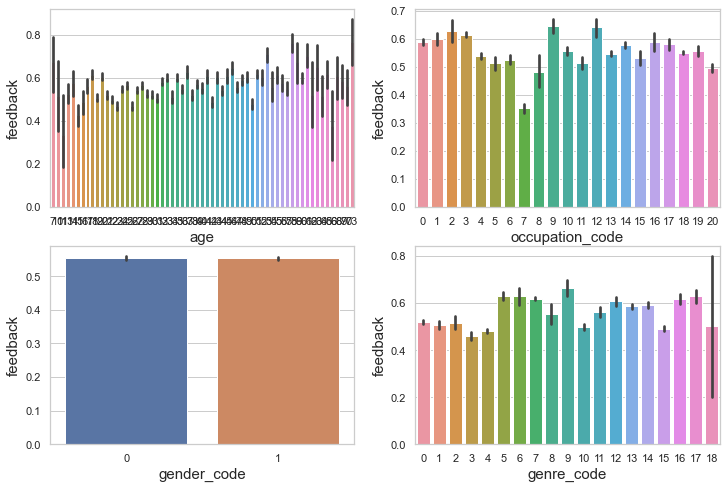

In [9]:
# Just quickly checking the distribution of feedback with bar charts without considering the visualisation itself
sns.set(style="whitegrid")
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.xlabel('age', size=15)
plt.ylabel('feedback', size=15)
sns.barplot(x = 'age', y = 'feedback', data = df_pred)
plt.subplot(2, 2, 2)
plt.xlabel('occupation_code', size=15)
plt.ylabel('feedback', size=15)
sns.barplot(x = 'occupation_code', y = 'feedback', data = df_pred)
plt.subplot(2, 2, 3)
plt.xlabel('gender_code', size=15)
plt.ylabel('feedback', size=15)
sns.barplot(x = 'gender_code', y = 'feedback', data = df_pred)
plt.subplot(2, 2, 4)
plt.xlabel('genre_code', size=15)
plt.ylabel('feedback', size=15)
sns.barplot(x = 'genre_code', y = 'feedback', data = df_pred)

We can see above how the feedback is distributed for each feature. The distribution of feedback by gender is almost equal. However, some fluctuations can be seen in the other features, which means that gender will not be useful when predicting feedback, but other features may be helpful in estimating.

In [10]:
# Have a look the correlations beetween featuares
df_pred.corr()

,feedback,age,genre_code,gender_code,occupation_code
feedback,1.000000,0.039317,0.041401,-0.001126,-0.022800
age,0.039317,1.000000,0.027601,0.033358,-0.369476
genre_code,0.041401,0.027601,1.000000,-0.001079,-0.011759
gender_code,-0.001126,0.033358,-0.001079,1.000000,0.017354
occupation_code,-0.022800,-0.369476,-0.011759,0.017354,1.000000


> The target(feedback) which we will predict, is not much correlated with the other features especially, as it was predicted before, with genders.

# Predictions
### Simple Logistic Regression model 

In [11]:
# Train and test all features together
train, test = train_test_split(df_pred, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(80000, 5)
(20000, 5)


In [12]:
columns = df_pred.columns.to_list()
columns

['feedback', 'age', 'genre_code', 'gender_code', 'occupation_code']

In [13]:
feature_cols = ['age', 'genre_code', 'gender_code', 'occupation_code']
X_train = train[feature_cols]
y_train = train['feedback']
# for testing
X_test = test[feature_cols]
y_test = test['feedback']

In [14]:
# Building our Logistic Regression model
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
predicted = logreg.predict(X_test)
print("MSE:", mean_squared_error(y_test, predicted))
print("R^2:", r2_score(y_test, predicted))
# Evaluating the accuracy of the trained model accuracy_score
from sklearn.metrics import accuracy_score
print("Accuracy score:", accuracy_score(y_test, predicted))

MSE: 0.44245
R^2: -0.7937708050250392
Accuracy score: 0.55755


In [15]:
# Evaluating the performance of the trained model with confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(y_test, predicted)

array([[  228,  8616],
       [  233, 10923]], dtype=int64)

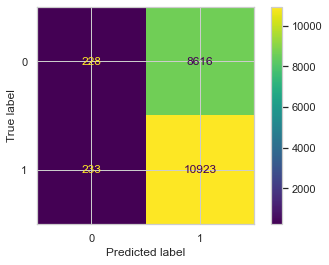

In [16]:
cm = ConfusionMatrixDisplay(y_test, predicted)
cm = confusion_matrix(y_test, predicted, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()
plt.show()
sns.set_style('dark')

Having looked at the visualization above,
* True positive and negative = 228+10923= 11151
* False negative and positive = 233+8616= 8849
* We can calculate the accuray manually as it is 11151/20000= 0.57755 (%57.76)

##### Feature Selection

In [17]:
from sklearn.feature_selection import RFE

estimator = LogisticRegression(C=1e9)
selector = RFE(estimator, 1)  # selecting the best estimator
selector = selector.fit(X_test, y_test)
supp = selector.get_support()
feature_cols_array = np.array(['age', 'genre_code', 'gender_code', 'occupation_code'])
print("Selected features:", feature_cols_array[supp])
print("Coeffs:", selector.estimator_.coef_)
# testing the model
predicted = selector.predict(X_test)
print("MSE:", mean_squared_error(y_test, predicted))
print("R^2:", r2_score(y_test, predicted))
print("Accuracy score:", accuracy_score(y_test, predicted))

Selected features: ['gender_code']
Coeffs: [[-0.03929571]]
MSE: 0.4422
R^2: -0.7927572606669055
Accuracy score: 0.5578


### Evaluation
After simple logistic regression, the result shows
* A negative R^2 (-0.79) which means the chosen model fits worse than a horizontal line(mean= 0.55375) 
* A high MSE ( 0.4426) which means the model is not predicting well the target
* An accuracy score(0.55755), the model predicted %55.75 of the outputs correctly.

Having looked at the features. 
* The mean of feedback is 0.55375 which means if we assume that all people like the movies they watch, then our accuracy rate would be the %55.375 as it is the same rate of the liked movies.

**Feature selection**
* Despite the correlations with feedback, feature selection function selected 'gender_code' as it is the best and 'genre_code' as it is the second best estimator for our model. However, our models accuracy almost did not change and so do MSE and R squared.


### K-nearest neighbour

In [18]:
# Creating and training a KNN classifier model
clf = KNeighborsClassifier(n_neighbors = 31) 
clf.fit(X_train, y_train)

# Using the model to predict testing data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print('Testing accuracy is: ', accuracy)

Testing accuracy is:  0.60635


###### *Remark*
> I assigned an estimated K value a few times to get the best accuracy rate above.
Alternatively, using the code below, we can see which K value has the lowest error rate.

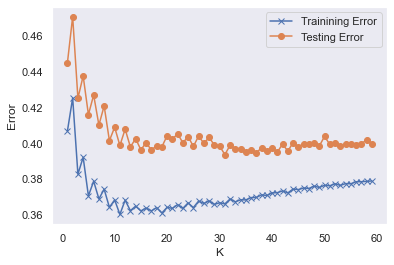

In [19]:
training_error = list()
testing_error = list()

for i in range(1, 60):
    clf = KNeighborsClassifier(n_neighbors = i)
    clf.fit(X_train, y_train)
    training_error.append(1.0-accuracy_score(clf.predict(X_train), y_train))
    testing_error.append(1.0-accuracy_score(clf.predict(X_test), y_test))

# Plot the relationship
plt.plot(range(1, 60), training_error, marker='x', label='Trainining Error')
plt.plot(range(1, 60), testing_error, marker='o', label='Testing Error')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend(loc='best')
plt.show()

>As we can see above, the best K value is the one with least error rate(31) for testing data.
it is 11 for the training data.

In [20]:
# Here we can see how the performance of our best predictor(gender) alone.
from sklearn.model_selection import cross_val_score
X = np.array(df_pred['gender_code'])
y = np.array(df_pred['feedback'])
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)
clf = KNeighborsClassifier(n_neighbors = 11)
scores = cross_val_score(clf, X, y, cv=11)
print('Accuracy for each round: \n', scores)
print('Average accuracy: %.4f +- %.4f' % (scores.mean(), scores.std()))

Accuracy for each round: 
 [0.5198548  0.55373446 0.4903751  0.55373446 0.55373446 0.47233528
 0.55373446 0.55373446 0.55373446 0.55384446 0.46446645]
Average accuracy: 0.5294 +- 0.0347


In [21]:
from sklearn.model_selection import GridSearchCV
# Defining search space for parameters
parameter_grid = {'n_neighbors': range(1, 40)}

# Creating the machine learning model
knn_clf = KNeighborsClassifier()
clf = GridSearchCV(knn_clf, parameter_grid, scoring='accuracy', cv=10)
clf.fit(X, y)

# Identifing the best parameter(s)
print('Best K value: ', clf.best_params_['n_neighbors'])
print('The accuracy: ', clf.best_score_)

Best K value:  31
The accuracy:  0.53752


## Summary
*When the data is examined*,
* it is seen that 4 different features can be used to predict feedbacks.These are 'age', 'gender', 'genre', 'occupation'. 
* 'Gender', 'age' and 'occupation' are the properties of users, while 'genre' is the property of movies.
* More than 55 percent of the feedbacks are positive(like), the rest are negative(dislike).

*Looking at the correlations*,
* The target(feedback) is not much correlated with the other features, but it is correlated with 'age' and 'genre' more than the other features.

*Logistic Regression and KNN*,
* Logistic Regression estimated the target with %55.76 accuracy rate as the correlations quite low with the features. its MSE was 0.44 and it provides a negative R squared as it was -0.79. Therefore, it was not a significant estimation.
* To improve its accuracy, KNN was applied and the estimation was successfully improved from %55.76 to %60.64.

*As a result*;
* The estimation was managed to imrove around %5; However, it is still not good enough to estimate the target variable.
* It can be conclude that, providing more correlated features, such as the budget of the movies, can improve the estimation and accuracy rate.